# Classifying traffic sign images

In this training I am going to reproduce the example of the chapter 12 of the book Deep Learning for Dummies, which consists of training a Convolutional Neural Network to recognize and classifies traffic signs in static images.
We are going to use the [GTSRB (German Traffic Sign Recognition Benchmark)](https://www.kaggle.com/datasets/meowmeowmeowmeowmeow/gtsrb-german-traffic-sign) Dataset, which contains more than 50.000 images and more than 40 classes.

In [22]:
import numpy as np
import zipfile
import pprint

from skimage.transform import resize
from imageio import imread

import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

In [23]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator 
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.layers import Flatten, Dense, Dropout

### Getting and Setting the dataset

First things first, let's download the dataset:

In [24]:
import urllib.request
import os.path
if not os.path.exists("GTSRB_Final_Training_Images.zip"):
    url = ("https://sid.erda.dk/public/archives/"
    + "daaeac0d7ce1152aea9b61d9f1e19370/"
    + "GTSRB_Final_Training_Images.zip")
    filename = "./GTSRB_Final_Training_Images.zip"
    urllib.request.urlretrieve(url, filename)

Here we are setting the size of the images (they will be resized in a little) and the size of the test set, that will be 20% of the full dataset. The others 80% will be used in the training phase.

In [25]:
IMG_SIZE = 32
TEST_SIZE = 0.2

Now we are going to read the dataset file, resize the images and append the image and its label to the training set (represented by the X and y variables) or to the test set (represented by the Xt and yt variables). 

To decide to which dataset the image will be appended we just calculate a integer hash of the file name and divide it by 1000, if the result is below 0.2 we append to the test set, otherwise we append to the training set.

In [26]:
X, Xt, y, yt = list(), list(), list(), list()

archive = zipfile.ZipFile(
          'GTSRB_Final_Training_Images.zip', 'r')
file_paths = [file for file in archive.namelist() 
              if '.ppm' in file]

for filename in file_paths:
    with archive.open(filename) as img_file:
        img = imread(img_file.read())
    img = resize(img, 
                 output_shape=(IMG_SIZE, IMG_SIZE),
                 mode='reflect', anti_aliasing=True)
    img_class = int(filename.split('/')[-2])
    
    if (hash(filename) % 1000) / 1000 > TEST_SIZE:
        X.append(img)
        y.append(img_class)
    else:
        Xt.append(img)
        yt.append(img_class)

archive.close()

In [27]:
test_ratio = len(Xt) / len(file_paths)
print("Train size:{} test size:{} ({:0.3f})".format(len(X), 
                len(Xt), 
                test_ratio))

Train size:31438 test size:7771 (0.198)


### Overfitting

Here we have an histogram of the class distribution along the dataset. As we can see, we have a total of 43 classes, but some classes are more present than others, and this could be a problem because the training can be more influentiated by some classes.

No classes:43


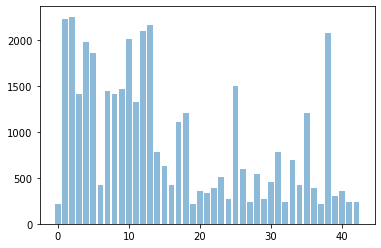

In [28]:
classes, dist = np.unique(y+yt, return_counts=True)
NUM_CLASSES = len(classes)
print ("No classes:{}".format(NUM_CLASSES))

plt.bar(classes, dist, align='center', alpha=0.5)
plt.show()

To solve that we are going to calculate some weights for the classes according to the frequency the classes appear.

Most common classes will have a higher weight, and less common classes will have a lower weight.

In [29]:
class_weight = {c:dist[c]/np.sum(dist) for c in classes}

most_frequent_class = np.where(dist == max(dist))[0][0]
print(f'Most common class in dataset: {most_frequent_class}; frequency: {dist[most_frequent_class]}; weight: {class_weight[most_frequent_class]}')

less_frequent_class = np.where(dist == min(dist))[0][0]
print(f'Less common class in dataset: {less_frequent_class}; frequency: {dist[less_frequent_class]}; weight: {class_weight[less_frequent_class]}')

Most common class in dataset: 2; frequency: 2250; weight: 0.05738478410569002
Less common class in dataset: 0; frequency: 210; weight: 0.005355913183197735


### More data

Now we are using a data augmentation strategy. The idea is to automatically generate extra data by applying runtime transformations on the training images. By doing that we can provide more data to the CNN during the training phase, what can reduce the invariance of the data and give a better result due to the higher number of training data presented to the network.

Here we applied re-scale, rotation, width and height shift transformations to the training images. For the test images we just resized the images.

In [30]:
batch_size = 256
tgen=ImageDataGenerator(rescale=1./255,
                        rotation_range=5,
                        width_shift_range=0.10, 
                        height_shift_range=0.10)

train_gen = tgen.flow(np.array(X), 
                      to_categorical(y), 
                      batch_size=batch_size)

vgen=ImageDataGenerator(rescale=1./255)

val_gen = vgen.flow(np.array(Xt), 
                    to_categorical(yt), 
                    batch_size=batch_size)

### The Network

Now let's create our network. It will be composed by:
1. Convolutional layer with 32 filters, kernel size 5x5, stride 1x1 and ReLU activation function
2. Convolutional layer with 64 filters, kernel size 5x5, stride 1x1 and ReLU activation function
3. Flatten layer to reshape the input to a unidimensional array
4. Dense layer with 768 neurons and ReLU activation function
5. Dropout of 40%, to prevent overfitting by deactivating some neurons randomly
6. Dense output layer with 43 neurons (the number of classes) and ReLU activation function

In [31]:
def small_cnn():
    model = Sequential()
    model.add(Conv2D(32, (5, 5), padding='same',
                     input_shape=(IMG_SIZE, IMG_SIZE, 3),
                     activation='relu'))
    model.add(Conv2D(64, (5, 5), activation='relu'))   
    model.add(Flatten())
    model.add(Dense(768, activation='relu'))
    model.add(Dropout(0.4))
    model.add(Dense(NUM_CLASSES, activation='softmax'))
    return model


model = small_cnn()
model.compile(loss='categorical_crossentropy', 
              optimizer=Adam(),
              metrics=['accuracy'])

### Training and evaluating the model

Finnaly, let's train the network with the dataset and classes weights

In [32]:
history = model.fit_generator(train_gen,
                              steps_per_epoch=len(X) // batch_size,
                              validation_data=val_gen,
                              validation_steps=len(Xt) // batch_size,
                              class_weight=class_weight,
                              epochs=10, 
                              verbose=2)

Epoch 1/10
 - 91s - loss: 3.0644 - acc: 0.0737 - val_loss: 3.4811 - val_acc: 0.1225
Epoch 2/10
 - 96s - loss: 2.7684 - acc: 0.1377 - val_loss: 3.0224 - val_acc: 0.2142
Epoch 3/10
 - 95s - loss: 2.3349 - acc: 0.2431 - val_loss: 2.1097 - val_acc: 0.4332
Epoch 4/10
 - 95s - loss: 1.8137 - acc: 0.3544 - val_loss: 1.6305 - val_acc: 0.5238
Epoch 5/10
 - 94s - loss: 1.5365 - acc: 0.4289 - val_loss: 1.3474 - val_acc: 0.5802
Epoch 6/10
 - 95s - loss: 1.3309 - acc: 0.4860 - val_loss: 1.1352 - val_acc: 0.6522
Epoch 7/10
 - 95s - loss: 1.1706 - acc: 0.5381 - val_loss: 0.9546 - val_acc: 0.7049
Epoch 8/10
 - 95s - loss: 1.0367 - acc: 0.5878 - val_loss: 0.7922 - val_acc: 0.7436
Epoch 9/10
 - 94s - loss: 0.9222 - acc: 0.6256 - val_loss: 0.6893 - val_acc: 0.7866
Epoch 10/10
 - 95s - loss: 0.8370 - acc: 0.6594 - val_loss: 0.5871 - val_acc: 0.8137


In [33]:
print("Best validation accuracy: {:0.3f}"
       .format(np.max(history.history['val_acc'])))

Best validation accuracy: 0.814


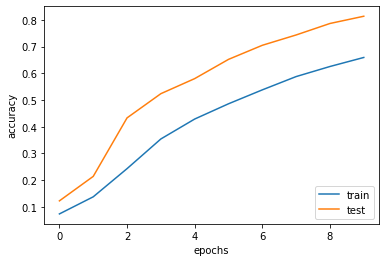

In [34]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.ylabel('accuracy'); plt.xlabel('epochs')
plt.legend(['train', 'test'], loc='lower right')
plt.show()

### A visual prediction demonstration

For a small visual demonstration, lets ask the model to predict the class of a new image that I manually got from Google: 

In [35]:
img_demonstration = imread("stop_sign_from_google_images.jpg")
img_demonstration = resize(img_demonstration, 
            output_shape=(IMG_SIZE, IMG_SIZE),
            mode='reflect', anti_aliasing=True)

demonstration_set = list()
demonstration_set.append(img_demonstration)

In [36]:
print("Generate a prediction")
prediction = model.predict(np.array(demonstration_set))

for idx in range(len(prediction[0])):
    if prediction[0][idx] != 0:
        print("Predicted Class: " + str(idx))
        break

Generate a prediction
Predicted Class: 14


To evaluate if the prediction is correct I took an class 14 image of the dataset, and this was the result:

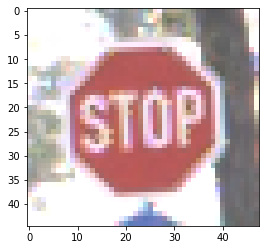

In [37]:
stop_image_from_dataset = imread("sample_training_image_class_14.ppm")
plt.imshow(stop_image_from_dataset)

And the image I got from Google was... 

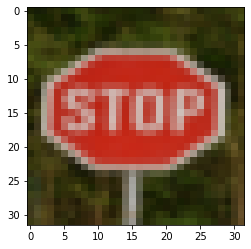

In [38]:
plt.imshow(img_demonstration)

## TA-DAAAA! :D